# 안녕하세요^^ 
# AIVLE 미니 프로젝트에 오신 여러분을 환영합니다.
* 본 과정에서는 실제 사례와 데이터를 기반으로 문제를 해결하는 전체 과정을 자기 주도형 실습으로 진행해볼 예정입니다.
* 앞선 교육과정을 정리하는 마음과 지금까지 배운 내용을 바탕으로 문제 해결을 해볼게요!
* 미니 프로젝트를 통한 문제 해결 과정 'A에서 Z까지', 지금부터 시작합니다!

---

In [1]:
# 필요한 라이브러리를 불러오세요.
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import scipy.stats as spst

from sklearn.metrics import *
from sklearn.preprocessing import *

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [58]:
# 시각화 한글폰트 설정

plt.rc('font', family='Malgun Gothic')
sns.set(font="Malgun Gothic",#"NanumGothicCoding", 
        rc={"axes.unicode_minus":False}, # 마이너스 부호 깨짐 현상 해결
        style='darkgrid')

---

---

# 1. 라이브러리 Import 및 데이터 불러오기

* sklearn 을 설치 하세요. 

* 관련 라이브러리들을 불러오세요

In [64]:
import pandas as pd

# 학습/평가 데이터 로딩
iter_data_21 = pd.read_csv("iter_data_21_rain.csv")
iter_data_22 = pd.read_csv("iter_data_22_rain.csv")
knn_data_21 = pd.read_csv("knn_data_21_rain.csv")
knn_data_22 = pd.read_csv("knn_data_22_rain.csv")

In [65]:
iter_x = iter_data_21.drop(columns='y', axis=1)
iter_y = iter_data_21['y']

knn_x = knn_data_21.drop(columns='y', axis=1)
knn_y = knn_data_21['y']

In [66]:
x_train_i, x_val_i, y_train_i, y_val_i = train_test_split(iter_x, iter_y, test_size=.3, shuffle=False)

In [67]:
x_train_k, x_val_k, y_train_k, y_val_k = train_test_split(knn_x, knn_y, test_size=.3, shuffle=False)

In [68]:
scaler = MinMaxScaler()
x_train_i_s = scaler.fit_transform(x_train_i)
x_val_i_s = scaler.fit_transform(x_val_i)

x_train_k_s = scaler.fit_transform(x_train_k)
x_val_k_s = scaler.fit_transform(x_val_k)

In [7]:
x_train_i.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6131 entries, 0 to 6130
Data columns (total 38 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   월              6131 non-null   float64
 1   시간             6131 non-null   float64
 2   년              6131 non-null   float64
 3   SO2            6131 non-null   float64
 4   CO             6131 non-null   float64
 5   O3             6131 non-null   float64
 6   NO2            6131 non-null   float64
 7   PM10           6131 non-null   float64
 8   PM25           6131 non-null   float64
 9   기온(°C)         6131 non-null   float64
 10  기온 QC플래그       6131 non-null   float64
 11  풍속(m/s)        6131 non-null   float64
 12  풍속 QC플래그       6131 non-null   float64
 13  풍향(16방위)       6131 non-null   float64
 14  풍향 QC플래그       6131 non-null   float64
 15  습도(%)          6131 non-null   float64
 16  습도 QC플래그       6131 non-null   float64
 17  증기압(hPa)       6131 non-null   float64
 18  이슬점온도(°C

---

In [8]:
def plot_model_result(y_train, y_val, pred) :
    pred = pd.Series(pred, index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (20,12))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()

In [52]:
def plot_feature_importance(importance, names):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df.reset_index(drop=True, inplace = True)

    plt.figure(figsize=(10,8))
    sns.barplot(x='feature_importance', y='feature_names', data = fi_df)

    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.grid()

    return fi_df

In [9]:
flag_col = ['기온 QC플래그', '풍속 QC플래그', '풍향 QC플래그', '습도 QC플래그', '현지기압 QC플래그', '해면기압 QC플래그', '지면온도 QC플래그', '일조 QC플래그', '일사 QC플래그']
wt_class_col = ['전운량(10분위)', '중하층운량(10분위)', '풍향(16방위)', '월', '시간', '년']
wt_num_col = ['기온(°C)', '풍속(m/s)', '습도(%)', '증기압(hPa)', '이슬점온도(°C)', '현지기압(hPa)', '해면기압(hPa)', '일조(hr)', '일사(MJ/m2)','시정(10m)', '지면온도(°C)', '5cm 지중온도(°C)', '10cm 지중온도(°C)', '20cm 지중온도(°C)', '30cm 지중온도(°C)']

In [10]:
nan_col = ['지면상태(지면상태코드)', '운형(운형약어)', '최저운고(100m )', '현상번호(국내식)',  '강수량 QC플래그']
nan_num = ['강수량(mm)', '적설(cm)', '3시간신적설(cm)']
drop_col = nan_col + nan_num

In [11]:
x_train_i_nf = x_train_i.drop(columns=flag_col, axis=1)
x_val_i_nf = x_val_i.drop(columns=flag_col, axis=1)

In [22]:
x_train_k_nf = x_train_k.drop(columns=flag_col, axis=1)
x_val_k_nf = x_val_k.drop(columns=flag_col, axis=1)

In [12]:
k = int(y_val_i.count() ** 0.5)
k

51

In [13]:
# params = {
#     'model_line' : {
#     }
#     , 'model_knnc' : {
#         'n_neighbors' : range(k-10, k+10)
#         , 'metric': ['euclidean', 'manhattan']
#     }
#     , 'model_svm' : {
#         'C': range(1,11)
#         , 'gamma' : np.linspace(0.01,1,20)
#     }
#     , 'model_ran' : {
#         'max_features' : range(1, x_train_i.shape[1] + 1)
#         , 'n_estimators' : range(10,151,10)
#     }
#     , 'model_xgb' : {
#         'max_depth' : [3, 5, 8]
#         , 'n_estimators':[50,100,150]
#         , 'learning_rate':np.linspace(0.01,1,20)
#     }
# }

params = {
    'model_svm' : {
        'C': range(1,11)
        , 'gamma' : np.linspace(0.01,1,10)
    }
    , 'model_ran' : {
        'max_features' : range(1, 10)
        , 'n_estimators' : range(10,101,10)
    }
    , 'model_xgb' : {
        'max_depth' : [3, 5, 8]
        , 'n_estimators':[50,100,150]
        , 'learning_rate':np.linspace(0.01,1,10)
    }
}

In [14]:
# model
model_line = LinearRegression()
model_knnc = KNeighborsRegressor()
model_svm = SVR()
model_ran = RandomForestRegressor()
model_xgb = XGBRegressor()
# model = {'model_line':model_line, 'model_knnc':model_knnc, 'model_svm':model_svm, 'model_ran':model_ran, 'model_xgb':model_xgb}
model = {'model_svm':model_svm, 'model_ran':model_ran, 'model_xgb':model_xgb}

### RandomForestRegressor

In [100]:
param = {'max_features' : range(7, 12)
        , 'n_estimators' : range(70,201,20)
        }

In [101]:
grid = GridSearchCV(model_ran, param, cv=5)
grid.fit(x_train_i, y_train_i)
pred_ = grid.predict(x_val_i)

rscore_ = r2_score(y_val_i, pred_)
mape_ = mean_absolute_percentage_error(y_val_i, pred_)
mae_ = mean_absolute_error(y_val_i, pred_)
rmse_ = mean_squared_error(y_val_i, pred_, squared=False)


In [ ]:
grid = GridSearchCV(model_ran, param, cv=5)
grid.fit(x_train_i_nf, y_train_i)
pred_ = grid.predict(x_val_i_nf)

rscore_ = r2_score(y_val_i, pred_)
mape_ = mean_absolute_percentage_error(y_val_i, pred_)
mae_ = mean_absolute_error(y_val_i, pred_)
rmse_ = mean_squared_error(y_val_i, pred_, squared=False)


In [102]:
print(grid.best_estimator_)
print(f'rscore : {rscore_}')
print(f'mape : {mape_}')
print(f'mae : {mae_}')
print(f'rmse : {rmse_}')
print('*' * 30)

RandomForestRegressor(max_features=11, n_estimators=90)
rscore : 0.923403742302315
mape : 0.34785090866002877
mae : 4.275203492611255
rmse : 7.000575344003453
******************************


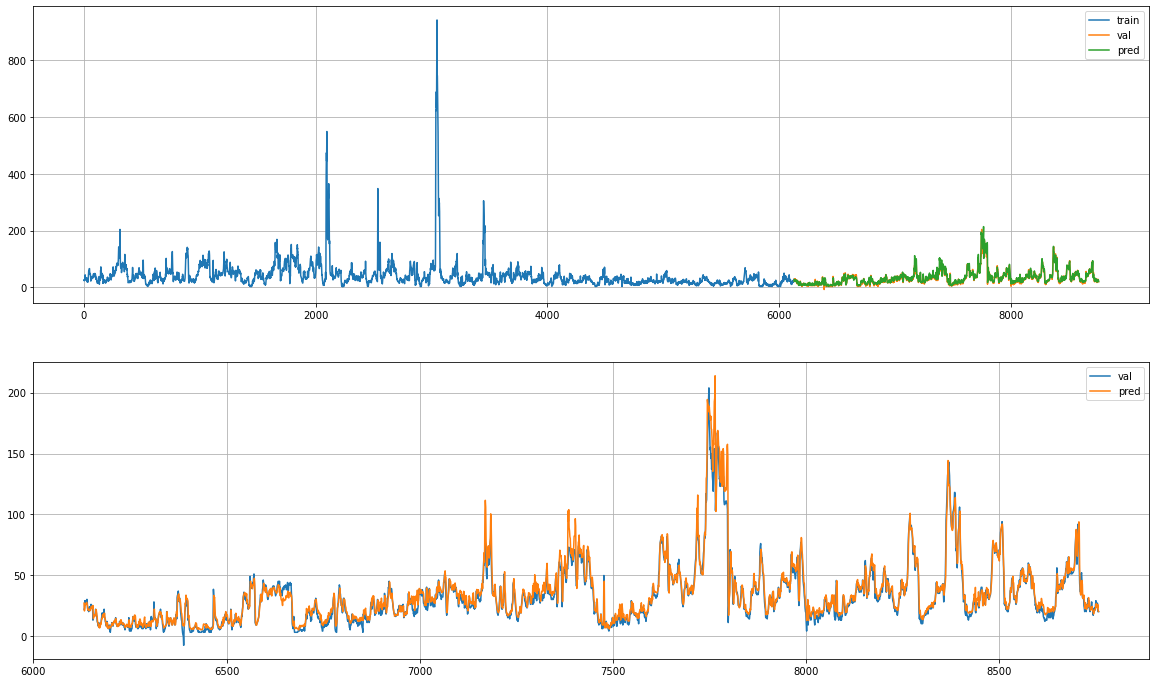

In [103]:
plot_model_result(y_train_i, y_val_i, pred_)

In [15]:
param = {
    'max_depth' : range(1,6)
    , 'n_estimators':range(70,151,20)
    , 'learning_rate':np.linspace(0.01,0.5,10)
}


In [16]:
grid = GridSearchCV(model_xgb, param, cv=5)
grid.fit(x_train_i, y_train_i)
pred_ = grid.predict(x_val_i)

rscore_ = r2_score(y_val_i, pred_)
mape_ = mean_absolute_percentage_error(y_val_i, pred_)
mae_ = mean_absolute_error(y_val_i, pred_)
rmse_ = mean_squared_error(y_val_i, pred_, squared=False)


In [17]:
print(grid.best_estimator_)
print(f'rscore : {rscore_}')
print(f'mape : {mape_}')
print(f'mae : {mae_}')
print(f'rmse : {rmse_}')
print('*' * 30)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.06444444444444444, max_bin=256,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=2, max_leaves=0,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=150, n_jobs=0, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, ...)
rscore : 0.955282879975789
mape : 0.2812904124310961
mae : 3.4886479012088487
rmse : 5.348929464340429
******************************


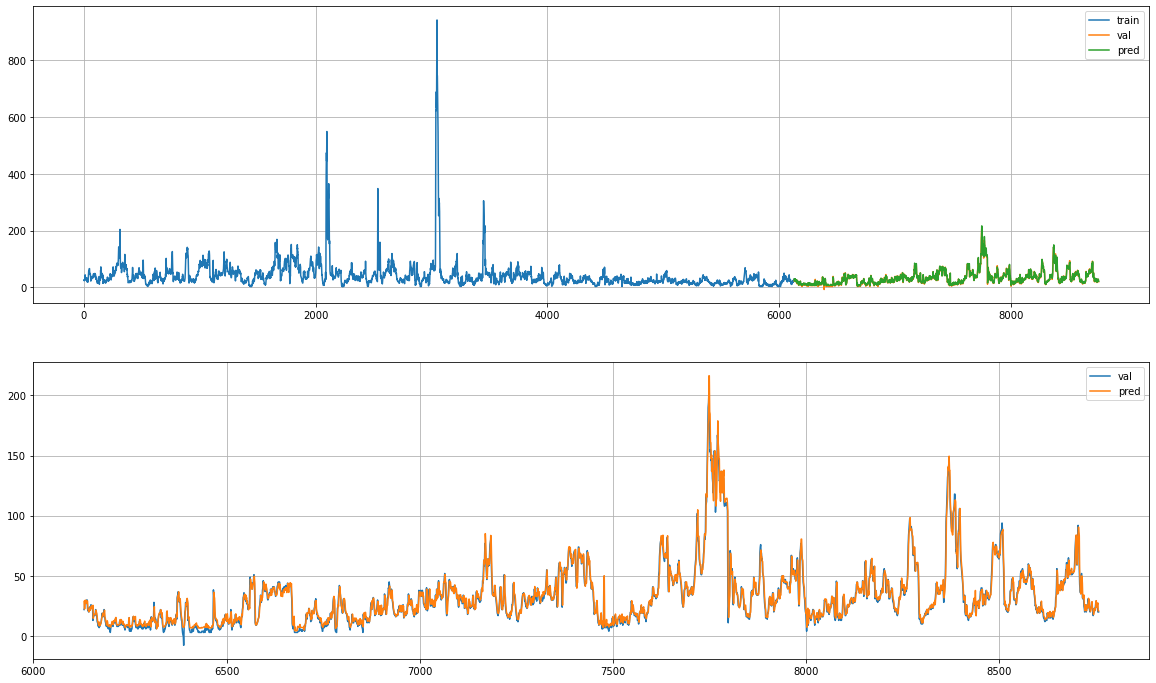

In [18]:
plot_model_result(y_train_i, y_val_i, pred_)

In [19]:
grid = GridSearchCV(model_xgb, param, cv=5)
grid.fit(x_train_i_nf, y_train_i)
pred_ = grid.predict(x_val_i_nf)

rscore_ = r2_score(y_val_i, pred_)
mape_ = mean_absolute_percentage_error(y_val_i, pred_)
mae_ = mean_absolute_error(y_val_i, pred_)
rmse_ = mean_squared_error(y_val_i, pred_, squared=False)


In [20]:
print(grid.best_estimator_)
print(f'rscore : {rscore_}')
print(f'mape : {mape_}')
print(f'mae : {mae_}')
print(f'rmse : {rmse_}')
print('*' * 30)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.06444444444444444, max_bin=256,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=2, max_leaves=0,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=150, n_jobs=0, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, ...)
rscore : 0.955282879975789
mape : 0.2812904124310961
mae : 3.4886479012088487
rmse : 5.348929464340429
******************************


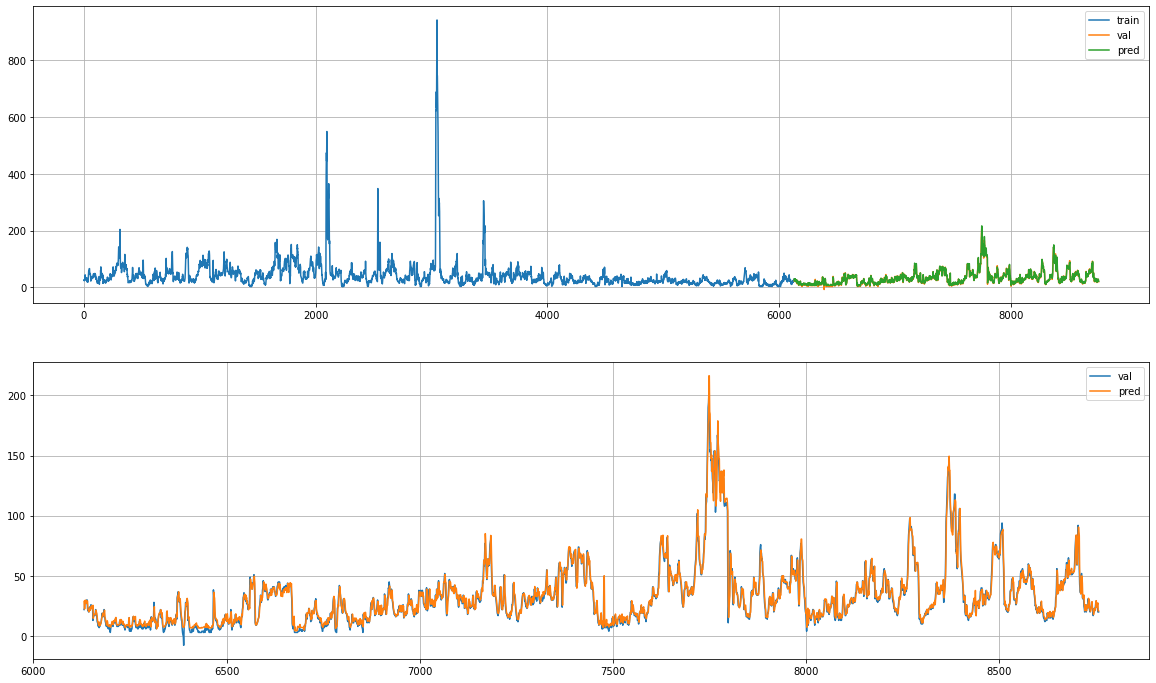

In [21]:
plot_model_result(y_train_i, y_val_i, pred_)

In [35]:
param = {
    'max_depth' : [3]
    , 'n_estimators':range(85,96)
    , 'learning_rate':np.linspace(0.01,0.3,10)
}


In [69]:
# grid = GridSearchCV(model_xgb, param, cv=5)
gird = XGBRegressor(learning_rate=0.138, max_depth=3, n_estimators=90)
grid.fit(x_train_k, y_train_k)
pred_ = grid.predict(x_val_k)

rscore_ = r2_score(y_val_k, pred_)
mape_ = mean_absolute_percentage_error(y_val_k, pred_)
mae_ = mean_absolute_error(y_val_k, pred_)
rmse_ = mean_squared_error(y_val_k, pred_, squared=False)


In [70]:
print(grid.best_estimator_)
print(f'rscore : {rscore_}')
print(f'mape : {mape_}')
print(f'mae : {mae_}')
print(f'rmse : {rmse_}')
print('*' * 30)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1388888888888889, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=91, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)
rscore : 0.9582386765068274
mape : 0.1478532319532375
mae : 3.37877476467571
rmse : 5.172115417308572
******************************


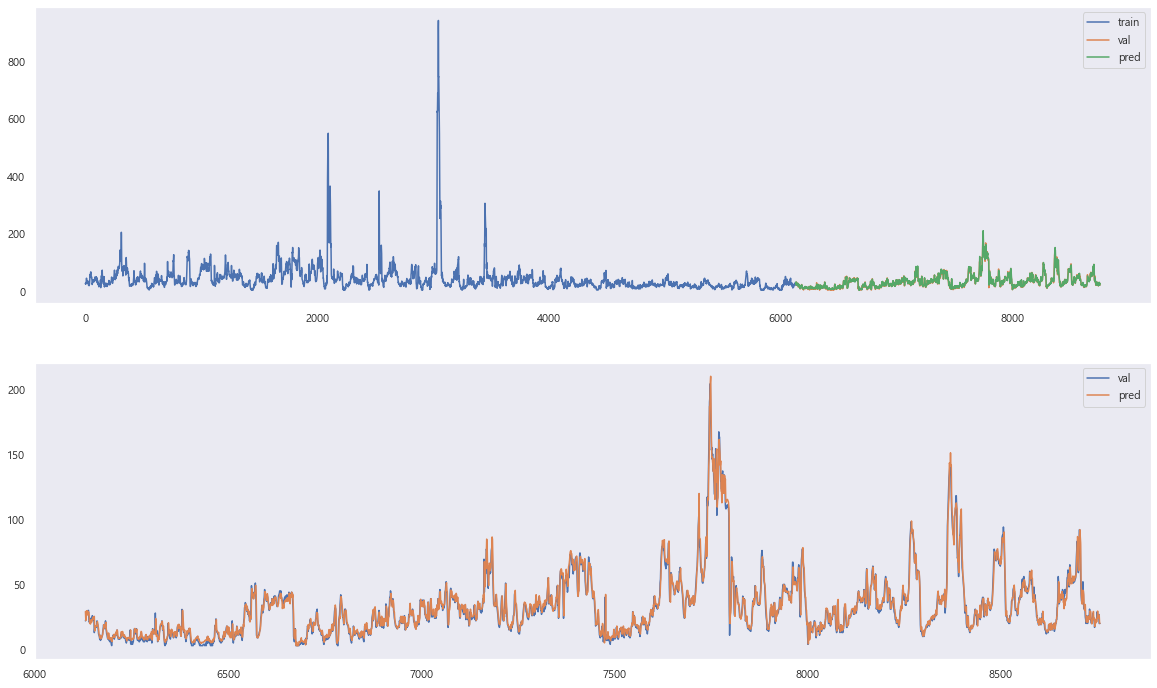

In [71]:
plot_model_result(y_train_k, y_val_k, pred_)

,feature_names,feature_importance
0,PM10,0.670800
1,PM25,0.170948
2,20cm 지중온도(°C),0.019086
3,현지기압(hPa),0.012685
4,시정(10m),0.012182
5,해면기압(hPa),0.011775
6,먼지현상,0.011632
7,30cm 지중온도(°C),0.011065
8,5cm 지중온도(°C),0.010377
9,습도(%),0.009564


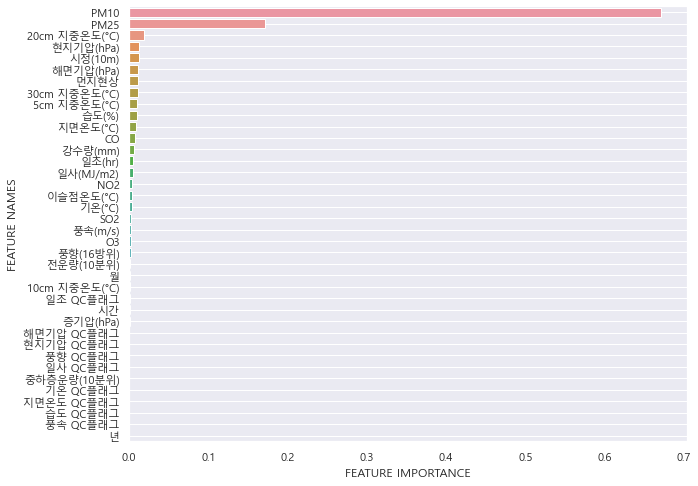

In [72]:
plot_feature_importance(grid.best_estimator_.feature_importances_, x_train_k.columns)

In [73]:
# grid = GridSearchCV(model_xgb, param, cv=5)
gird = XGBRegressor(learning_rate=0.138, max_depth=4, n_estimators=90)
grid.fit(x_train_k_nf, y_train_k)
pred_ = grid.predict(x_val_k_nf)

rscore_ = r2_score(y_val_k, pred_)
mape_ = mean_absolute_percentage_error(y_val_k, pred_)
mae_ = mean_absolute_error(y_val_k, pred_)
rmse_ = mean_squared_error(y_val_k, pred_, squared=False)


In [74]:
print(grid.best_estimator_)
print(f'rscore : {rscore_}')
print(f'mape : {mape_}')
print(f'mae : {mae_}')
print(f'rmse : {rmse_}')
print('*' * 30)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1388888888888889, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=89, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)
rscore : 0.9587993336410989
mape : 0.14908864917021644
mae : 3.3988126274294683
rmse : 5.137279573461357
******************************


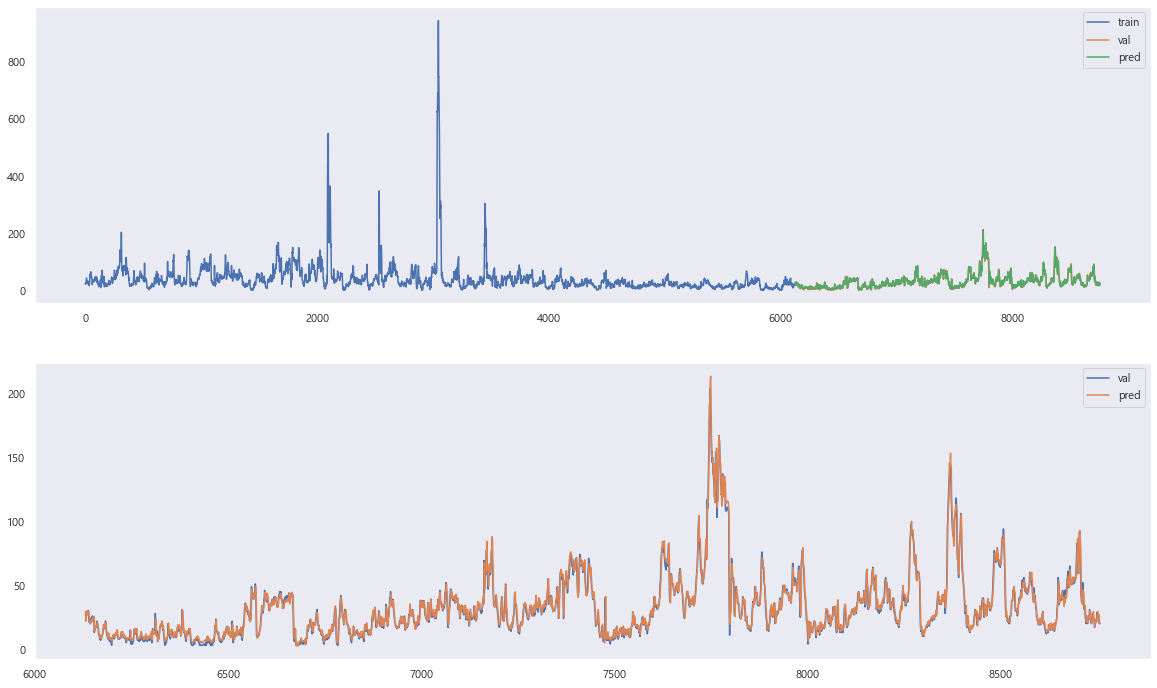

In [75]:
plot_model_result(y_train_k, y_val_k, pred_)

,feature_names,feature_importance
0,PM10,0.684475
1,PM25,0.160861
2,20cm 지중온도(°C),0.018302
3,30cm 지중온도(°C),0.012838
4,5cm 지중온도(°C),0.011625
5,해면기압(hPa),0.011466
6,현지기압(hPa),0.011001
7,시정(10m),0.010782
8,먼지현상,0.009513
9,습도(%),0.009091


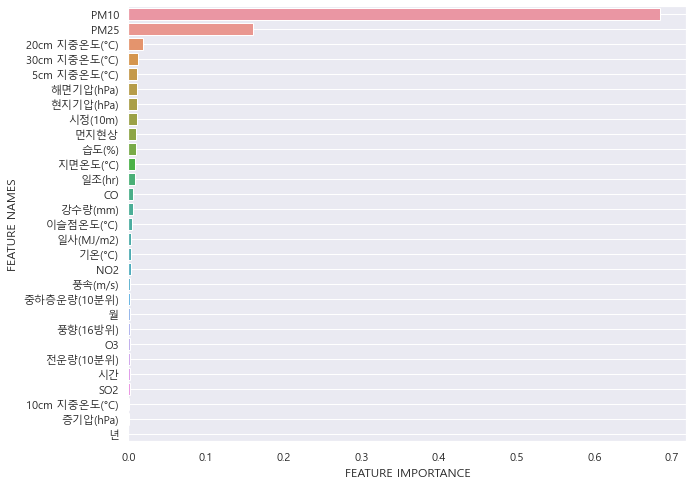

In [76]:
plot_feature_importance(grid.best_estimator_.feature_importances_, x_train_k_nf.columns)

In [82]:
knn_data_21.groupby(by='먼지현상')['y'].count()

먼지현상
0    8425
1     334
Name: y, dtype: int64

In [81]:
knn_data_21.loc[knn_data_21['먼지현상'] == 1].groupby(by='월')['먼지현상'].count()

월
1.0      18
2.0      51
3.0     139
4.0      31
5.0      43
6.0       3
7.0       2
10.0      3
11.0     28
12.0     16
Name: 먼지현상, dtype: int64

# 2. Modeling
## 이제 모델링을 해봅시다!
+ KeyPoint : 머신러닝 라이브러리를 토대로 모델링을 할 수 있다.

### 가. LinearRegression 부터 시작해봅시다.

#### [실습문제2] 머신러닝_1
* Train과 Test로 나눈 데이터를 기준으로 LinearRegression 모델링을 진행하고 평가를 해주세요.
* 그리고 모델 파일을 pkl로 저장해주세요.
* 성능지표 : RMSE, R-squared Score(소수점 5째자리까지, 반올림)

In [ ]:
# 아래에 실습코드를 작성하세요.





In [ ]:
# Test 데이터로 성능을 평가해보세요.





In [ ]:
# 학습한 모델을 파일로 저장해보세요.





### 나. 다음은 앙상블 기법을 토대로 랜덤포레스트와 그라디언브스팅을 활용해봅시다.

#### 1) 렌덤포레스트
##### 배깅의 일종으로 의사결정나무(Decision Tree) 여러 개를 모아서 숲을 랜덤으로 구성하고 이를 종합해서 최종 모델을 산출하는 기법이라고 할 수 있다.

#### [실습문제3] 머신러닝_2
* Train과 Test로 나눈 데이터를 기준으로 렌덤포레스트로 모델을 학습을 진행하고 평가를 해주세요.
* 그리고 모델 파일을 pkl로 저장해주세요.
* 성능지표 : RMSE, R-squared Score(소수점 5째자리까지, 반올림)

In [ ]:
# 아래에 실습코드를 작성하세요.





In [ ]:
# Test 데이터로 성능을 평가해보세요.





In [ ]:
# 학습한 모델을 파일로 저장해보세요.





#### [실습문제4] 머신러닝_3
* 렌덤포레스트로 학습한 모델의 feature_importances 또는 Shap value를 구해보세요.
* 확인할 수 있는 내용으로 우리 모델에서의 인사이트를 정리해보세요.

In [ ]:
# Feature의 중요도 확인






In [ ]:
# 확인할 수 있는 인사이트
# 1.
# 2.
# 3.

#### 2) GradientBoosting
##### 앞선 모델의 에러를 다음 모델의 예측 값으로 활용하면서 가중치 업데이트 하는데 경사하강법(Gradient Descent)를 활용해서 최적 모델을 만드는 기법

#### [실습문제5] 머신러닝_4
* Train과 Test로 나눈 데이터를 기준으로 그라디언트부스팅으로 모델을 학습을 진행하고 평가를 해주세요.
* 그리고 모델 파일을 pkl로 저장해주세요.
* 성능지표 : RMSE, R-squared Score(소수점 5째자리까지, 반올림)

In [ ]:
# 아래에 실습코드를 작성하세요.





In [ ]:
# Test 데이터로 성능을 평가해보세요.





In [ ]:
# 학습한 모델을 파일로 저장해보세요.





#### [실습문제6] 머신러닝_5
* 그라디언트부스팅으로 학습한 모델의 feature_importances 또는 Shap value를 구해보세요.
* 확인할 수 있는 내용으로 우리 모델에서의 인사이트를 정리해보세요.

In [ ]:
# Feature의 중요도 확인





In [ ]:
# 확인할 수 있는 인사이트
# 1.
# 2.
# 3.

#### 3) Self Choice Model
##### 앞선 교육과정에서 배운 머신러닝 모델 중 어떤 것이든 좋습니다. 원하는 모델을 선택해서 학습을 시켜보세요.

#### [실습문제7] 머신러닝_6
* Train과 Test로 나눈 데이터를 기준으로 Self Choice Model로 모델을 학습을 진행하고 평가를 해주세요.
* 그리고 모델 파일을 pkl로 저장해주세요.
* 성능지표 : RMSE, R-squared Score(소수점 5째자리까지, 반올림)

In [ ]:
# 아래에 실습코드를 작성하세요.





In [ ]:
# Test 데이터로 성능을 평가해보세요.





In [ ]:
# 학습한 모델을 파일로 저장해보세요.





#### [실습문제8] 머신러닝_7
* Self Choice Model로 학습한 모델의 feature_importances 또는 Shap value를 구해보세요.
* 확인할 수 있는 내용으로 우리 모델에서의 인사이트를 정리해보세요.

In [ ]:
# Feature의 중요도 확인





In [ ]:
# 확인할 수 있는 인사이트
# 1.
# 2.
# 3.